In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pycaret.time_series import *
from sklearn.metrics import (
    mean_absolute_error,
    mean_absolute_percentage_error,
    r2_score,
)
from statsmodels.tsa.deterministic import Fourier

# Load data
df = pd.read_csv("CSV\export-jsps001-1h.csv")
df["timestamp"] = pd.to_datetime(df["timestamp"], format="mixed")
df.set_index("timestamp", inplace=True)

# Keep only the last 1 year of data
one_year_ago = df.index.max() - pd.DateOffset(years=2)
df = df[df.index >= one_year_ago]

# Drop unnecessary columns
df.drop(columns=["timezone", "Unnamed: 0", "pm_2_5_sp","location" ,"pm_10"], inplace=True, errors="ignore")

# Resample to hourly and fill missing values

# Remove outliers using IQR
Q1 = df["pm_2_5"].quantile(0.25)
Q3 = df["pm_2_5"].quantile(0.75)
IQR = Q3 - Q1
df = df[(df["pm_2_5"] >= Q1 - 1.5 * IQR) & (df["pm_2_5"] <= Q3 + 1.5 * IQR)]

Q1t = df["temperature"].quantile(0.25)
Q3t = df["temperature"].quantile(0.75)
IQRt = Q3t - Q1t
df = df[(df["temperature"] >= Q1t - 1.5 * IQRt) & (df["temperature"] <= Q3t + 1.5 * IQRt)]

Q1h = df["humidity"].quantile(0.25)
Q3h = df["humidity"].quantile(0.75)
IQRh = Q3h - Q1h
df = df[(df["humidity"] >= Q1h - 1.5 * IQRh) & (df["humidity"] <= Q3h + 1.5 * IQRh)]
print(df)
df.interpolate(method="linear", inplace=True)

df = df.resample("D").mean().fillna(method="ffill")

# ✅ ปรับขนาดข้อมูลเป็น 4 ช่วงต่อวัน (ทุก 6 ชั่วโมง)
df = df.resample("D").mean()

# ✅ Fourier Terms (Weekly Seasonality) สำหรับ 4 ช่วงต่อวัน
fourier = Fourier(
    period=7, order=2
)  # Weekly seasonality with lower order (4 periods/day × 7 days)
fourier_features = fourier.in_sample(df.index)
df = pd.concat([df, fourier_features], axis=1)
df.dropna(inplace=True)

# ✅ เพิ่ม Lag Features หลายระดับ (Short-Term & Long-Term) สำหรับ 4 ช่วงต่อวัน
for lag in [
    7 +1,
    7 + 3,
    7 + 7,
    7 + 14,
]:  # 1 วัน, 2 วัน, 3 วัน, 7 วัน, 14 วัน (ปรับสเกลเป็น 4 ช่วงต่อวัน)
    df[f"pm_2_5_lag{lag}"] = df["pm_2_5"].shift(lag)
    df[f"humidity_lag{lag}"] = df["humidity"].shift(lag)
    df[f"temperature_lag{lag}"] = df["temperature"].shift(lag)

# ✅ เพิ่ม Rolling Mean และ Rolling Std หลายระดับ
for window in [2, 3, 5,7,14]:  # 1 วัน, 3 วัน, 7 วัน, 14 วัน (ปรับสเกลเป็น 4 ช่วงต่อวัน)
    df[f"pm_2_5_rollmean{window}"] = (
        df["pm_2_5"].shift(7).rolling(window=window, min_periods=1).mean()
    )
    df[f"pm_2_5_rollstd{window}"] = (
        df["pm_2_5"].shift(7).rolling(window=window, min_periods=1).std()
    )
    # df[f"temperature_rollmean{window}"] = (
    #     df["temperature"].shift(7).rolling(window=window, min_periods=1).mean()
    # )
    # df[f"temperature_rollstd{window}"] = (
    #     df["temperature"].shift(7).rolling(window=window, min_periods=1).std()
    # )
    df[f"humidity_rollmean{window}"] = (
        df["humidity"].shift(7).rolling(window=window, min_periods=1).mean()
    )
    df[f"humidity_rollstd{window}"] = (
        df["humidity"].shift(7).rolling(window=window, min_periods=1).std()
    )
    df[f"temperature_rollmean{window}"] = (
        df["temperature"].shift(7).rolling(window=window, min_periods=1).mean()
    )
    df[f"temperature_rollstd{window}"] = (
        df["temperature"].shift(7).rolling(window=window, min_periods=1).std()
    )

df = df.drop(columns=["temperature","humidity"])
df = df.asfreq("D").fillna(method="bfill")  # เติมข้อมูลก่อนแบ่ง


# แบ่งข้อมูลสำหรับฝึกและทดสอบ (7 วัน = 28 ช่วง)
train = df.iloc[:-7]  # แบ่ง train
test = df.iloc[-7:]  # แบ่ง test

# ✅ เลือกเฉพาะฟีเจอร์ที่สำคัญ
selected_features = ["pm_2_5"] + [col for col in df.columns if col != "pm_2_5"]
train = train[selected_features]
test = test[selected_features]

                       humidity     pm_2_5  temperature
timestamp                                              
2023-02-11 00:00:00  100.000000  19.833333    27.989750
2023-02-11 01:00:00  100.000000  18.408333    27.764417
2023-02-11 02:00:00  100.000000  15.925000    27.582000
2023-02-11 03:00:00  100.000000  18.436975    26.994286
2023-02-11 04:00:00  100.000000  20.958678    26.720248
...                         ...        ...          ...
2025-02-10 20:00:00   70.651656  26.825000    28.379455
2025-02-10 21:00:00   71.649910  25.441667    27.974364
2025-02-10 22:00:00   71.973936  26.056075    27.943536
2025-02-10 23:00:00   73.265868  30.033613    27.713126
2025-02-11 00:00:00   76.032920  32.516667    26.894614

[16440 rows x 3 columns]


In [20]:
train


,pm_2_5,"sin(1,7)","cos(1,7)","sin(2,7)","cos(2,7)",pm_2_5_lag8,humidity_lag8,temperature_lag8,pm_2_5_lag10,humidity_lag10,...,humidity_rollmean7,humidity_rollstd7,temperature_rollmean7,temperature_rollstd7,pm_2_5_rollmean14,pm_2_5_rollstd14,humidity_rollmean14,humidity_rollstd14,temperature_rollmean14,temperature_rollstd14
timestamp,,,,,,,,,,,,,,,,,,,,,
2023-02-11,15.871005,0.000000e+00,1.000000,0.000000e+00,1.000000,15.871005,99.610472,29.856016,15.871005,99.610472,...,99.610472,0.266159,29.856016,0.508677,15.871005,4.888161,99.610472,0.266159,29.856016,0.508677
2023-02-12,22.783909,7.818315e-01,0.623490,9.749279e-01,-0.222521,15.871005,99.610472,29.856016,15.871005,99.610472,...,99.610472,0.266159,29.856016,0.508677,15.871005,4.888161,99.610472,0.266159,29.856016,0.508677
2023-02-13,34.546132,9.749279e-01,-0.222521,-4.338837e-01,-0.900969,15.871005,99.610472,29.856016,15.871005,99.610472,...,99.610472,0.266159,29.856016,0.508677,15.871005,4.888161,99.610472,0.266159,29.856016,0.508677
2023-02-14,33.836666,4.338837e-01,-0.900969,-7.818315e-01,0.623490,15.871005,99.610472,29.856016,15.871005,99.610472,...,99.610472,0.266159,29.856016,0.508677,15.871005,4.888161,99.610472,0.266159,29.856016,0.508677
2023-02-15,27.525196,-4.338837e-01,-0.900969,7.818315e-01,0.623490,15.871005,99.610472,29.856016,15.871005,99.610472,...,99.610472,0.266159,29.856016,0.508677,15.871005,4.888161,99.610472,0.266159,29.856016,0.508677
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-31,35.541215,-7.818315e-01,0.623490,-9.749279e-01,-0.222521,44.745669,71.791901,28.178840,41.972714,74.482712,...,74.588658,2.369173,27.815805,0.998160,37.663457,8.560633,75.964419,5.013677,27.015458,1.128769
2025-02-01,43.223439,-6.075486e-14,1.000000,-1.215097e-13,1.000000,40.814330,76.526080,28.512929,39.911101,72.313270,...,74.415298,2.151392,28.153811,0.743568,38.497139,8.202786,75.743182,4.916559,27.164370,1.194118
2025-02-02,51.714844,7.818315e-01,0.623490,9.749279e-01,-0.222521,40.575321,76.329034,28.605586,44.745669,71.791901,...,74.198208,1.943084,28.487084,0.236422,38.861900,7.844349,75.775327,4.911250,27.392609,1.188265


In [21]:
# ✅ เพิ่ม fold เป็น 5 เพื่อให้โมเดล Generalize ขึ้น
experiment = setup(
    data=train,
    target="pm_2_5",
    session_id=123,
    use_gpu=True,
    fh=7,  # Forecast horizon = 7 days (28 periods)
    fold=2,
    seasonal_period="D",
    verbose=True,
)
test.index = test.index.to_period("D")

# ✅ ลองโมเดล ARIMA ก่อน
arima_model = create_model("arima")
arima_model = tune_model(arima_model)
final_arima = finalize_model(arima_model)

# Predict using the finalized model
X_forecast = test.drop(columns=["pm_2_5"])

,Description,Value
0,session_id,123
1,Target,pm_2_5
2,Approach,Univariate
3,Exogenous Variables,Present
4,Original data shape,"(725, 47)"
5,Transformed data shape,"(725, 47)"
6,Transformed train set shape,"(718, 47)"
7,Transformed test set shape,"(7, 47)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: Intel(R) UHD Graphics 630, Vendor: Intel(R) Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no m

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2025-01-14,1.3945,1.2645,11.6903,13.4559,0.3313,0.3545,-0.8368
1,2025-01-21,0.8170,0.7368,6.8644,7.8469,0.2093,0.1914,-0.4924
Mean,NaT,1.1057,1.0006,9.2774,10.6514,0.2703,0.2729,-0.6646
SD,NaT,0.2887,0.2638,2.4129,2.8045,0.0610,0.0815,0.1722


,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2025-01-14,1.1449,1.1483,9.5978,12.2192,0.3479,0.2642,-0.5147
1,2025-01-21,0.8694,0.7277,7.3051,7.7503,0.2156,0.2124,-0.4559
Mean,NaT,1.0071,0.9380,8.4515,9.9848,0.2817,0.2383,-0.4853
SD,NaT,0.1377,0.2103,1.1463,2.2345,0.0661,0.0259,0.0294


Fitting 2 folds for each of 10 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  1.5min finished


MAE: 2.59
MAPE: 8.34%
R2: -1.03
accurent: 91.66


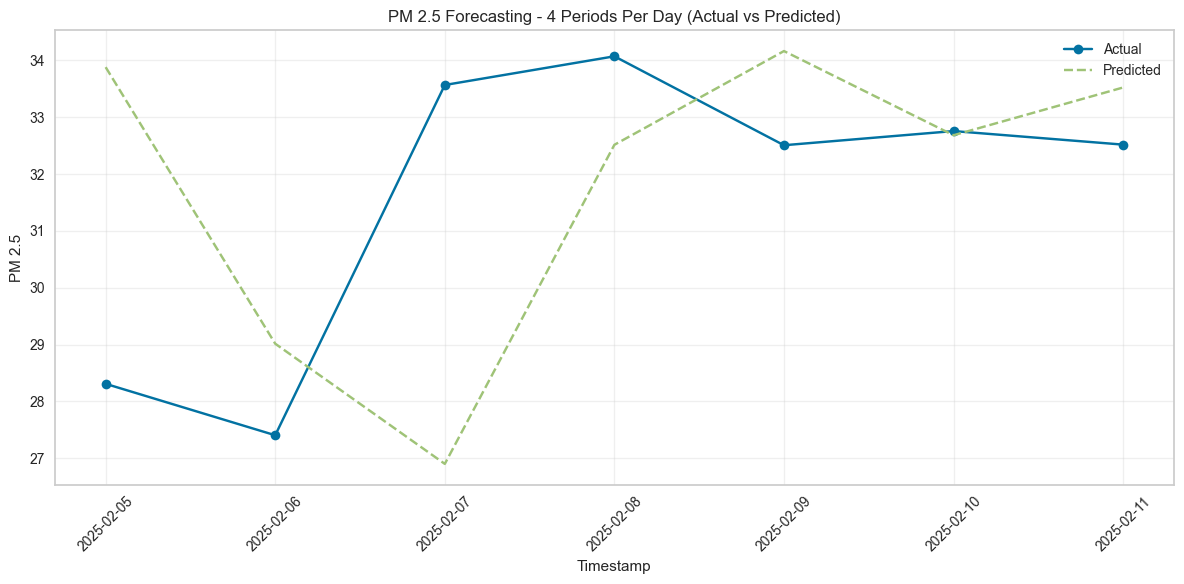

In [22]:
predictions = predict_model(final_arima, X=X_forecast)

# Evaluate Performance
mae = mean_absolute_error(test["pm_2_5"], predictions)
mape = mean_absolute_percentage_error(test["pm_2_5"], predictions) * 100
r2 = r2_score(test["pm_2_5"], predictions)
accurent = 100 - mape

print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"R2: {r2:.2f}")
print(f"accurent: {accurent:.2f}")

# ✅ แปลง Index ของ test ให้เป็น Timestamp ก่อนทำการ Plot
plt.figure(figsize=(12, 6))
plt.plot(
    test["pm_2_5"].index.to_timestamp(), test["pm_2_5"], label="Actual", marker="o"
)
plt.plot(
    test["pm_2_5"].index.to_timestamp(),
    predictions,
    label="Predicted",
    linestyle="--",
    marker="x",
)
plt.title("PM 2.5 Forecasting - 4 Periods Per Day (Actual vs Predicted)")
plt.xlabel("Timestamp")
plt.ylabel("PM 2.5")
plt.legend()
plt.grid(True, alpha=0.3)

# เพิ่มการแสดงช่วงเวลาให้ชัดเจนขึ้น
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [23]:
save_model(final_arima, "jsps001")

Transformation Pipeline and Model Successfully Saved


(ForecastingPipeline(steps=[('forecaster',
                             TransformedTargetForecaster(steps=[('model',
                                                                 ForecastingPipeline(steps=[('forecaster',
                                                                                             TransformedTargetForecaster(steps=[('model',
                                                                                                                                 ARIMA(order=(0,
                                                                                                                                              1,
                                                                                                                                              1),
                                                                                                                                       seasonal_order=(0,
                                                

In [1]:
# ✅ แปลง Index ของ test ให้เป็น Timestamp ก่อนทำการ Plot
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np

# ตั้งค่า Style ของกราฟให้สวยงามขึ้น
sns.set_style("whitegrid")
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'Helvetica', 'sans-serif']

# สร้างภาพที่มีขนาดใหญ่ขึ้น
plt.figure(figsize=(14, 8))

# แปลงข้อมูลให้อยู่ในรูปแบบที่สามารถเข้าถึงได้
actual_values = test["pm_2_5"].values
pred_values = predictions.values if hasattr(predictions, 'values') else np.array(predictions)
timestamps = test["pm_2_5"].index.to_timestamp()

# Plot ข้อมูลจริงและข้อมูลทำนาย
plt.plot(timestamps, actual_values, 
         label="Actual", marker="o", markersize=8, color="#1E88E5", linewidth=2)
plt.plot(timestamps, pred_values, 
         label="Predicted", linestyle="--", marker="x", markersize=8, 
         color="#D81B60", linewidth=2)

# คำนวณค่า error เฉลี่ยนอกลูป
mean_abs_error = np.mean(np.abs(actual_values - pred_values))

# เพิ่ม Annotation สำหรับแสดงค่า Error (ใช้วิธีเข้าถึงโดยตรงแทนการใช้ index)
for i in range(len(timestamps)):
    actual = float(actual_values[i])  # แปลงเป็น float ธรรมดา
    predicted = float(pred_values[i])  # แปลงเป็น float ธรรมดา
    error = actual - predicted
    if abs(error) > mean_abs_error:  # แสดงเฉพาะค่า error ที่มากกว่าค่าเฉลี่ย
        plt.annotate(f"{error:.1f}", 
                     xy=(timestamps[i], (actual + predicted)/2), 
                     xytext=(5, 0), 
                     textcoords="offset points", 
                     fontsize=9, 
                     color="darkslategray", 
                     bbox=dict(boxstyle="round,pad=0.3", fc="lightyellow", ec="orange", alpha=0.8))

# เพิ่ม Shaded area ระหว่างเส้นจริงและเส้นทำนาย
plt.fill_between(timestamps, actual_values, pred_values, 
                 color='lightgray', alpha=0.3, 
                 label='Error')

# ตั้งค่าหัวข้อและป้ายกำกับ
plt.title("PM 2.5 Forecasting - Actual vs Predicted", fontsize=18, pad=20)
plt.xlabel("Date & Time", fontsize=14, labelpad=10)
plt.ylabel("PM 2.5 (μg/m³)", fontsize=14, labelpad=10)

# ปรับแต่งแกน X
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%b %H:%M'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.xticks(rotation=45)

# แสดงเส้นกริดแนวนอน
plt.grid(axis='y', linestyle='--', alpha=0.7)

# เพิ่มข้อมูลสถิติลงในกราฟ
stats_text = (f"MAE: {float(mae):.2f}\n"
              f"MAPE: {float(mape):.2f}%\n"
              f"R²: {float(r2):.2f}\n"
              f"Accuracy: {float(accurent):.2f}%")

props = dict(boxstyle='round', facecolor='white', alpha=0.7, edgecolor='gray')
plt.text(0.02, 0.97, stats_text, transform=plt.gca().transAxes, fontsize=12,
        verticalalignment='top', bbox=props)

# ปรับแต่ง Legend
plt.legend(loc='lower right', fontsize=12, framealpha=0.8, facecolor='white', edgecolor='gray')

# ปรับขอบของกราฟ
plt.tight_layout()

# แสดงกราฟ
plt.show()

NameError: name 'test' is not defined

<Figure size 1400x800 with 0 Axes>